### Library Import

In [21]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.sanity import *

In [22]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [23]:
from src.load_datasets import load_traffic_data


dataframe = (
    load_traffic_data()
    .pipe(
        select_column,
        cols=[
            "date_time",
            "temp",
            "rain_1h",
            "snow_1h",
            "clouds_all",
            "traffic_volume",
        ],
    )
    .pipe(format_datetime, col="date_time")
    .pipe(set_index, col="date_time")
    .pipe(resample_data, freq="H")
    .pipe(interpolate_column)
)

print(f"dataframe shape {dataframe.shape}")

dataframe.head()

dataframe shape (52551, 5)


,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0


In [24]:
dataframe.isna().sum()

temp              0
rain_1h           0
snow_1h           0
clouds_all        0
traffic_volume    0
dtype: int64

In [25]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
temp,1.000000,0.007676,-0.018574,-0.032577,0.131058
rain_1h,0.007676,1.000000,-0.000059,0.003462,0.005204
snow_1h,-0.018574,-0.000059,1.000000,0.021784,0.001282
clouds_all,-0.032577,0.003462,0.021784,1.000000,0.024472
traffic_volume,0.131058,0.005204,0.001282,0.024472,1.000000


### Test Train split

train_xy and test_xy size: (52521, 5), (30, 5)

y_train and x_train size (52521,), (52521, 4)
y_test  and x_test  size (30,),  (30, 4)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='traffic_volume'>)

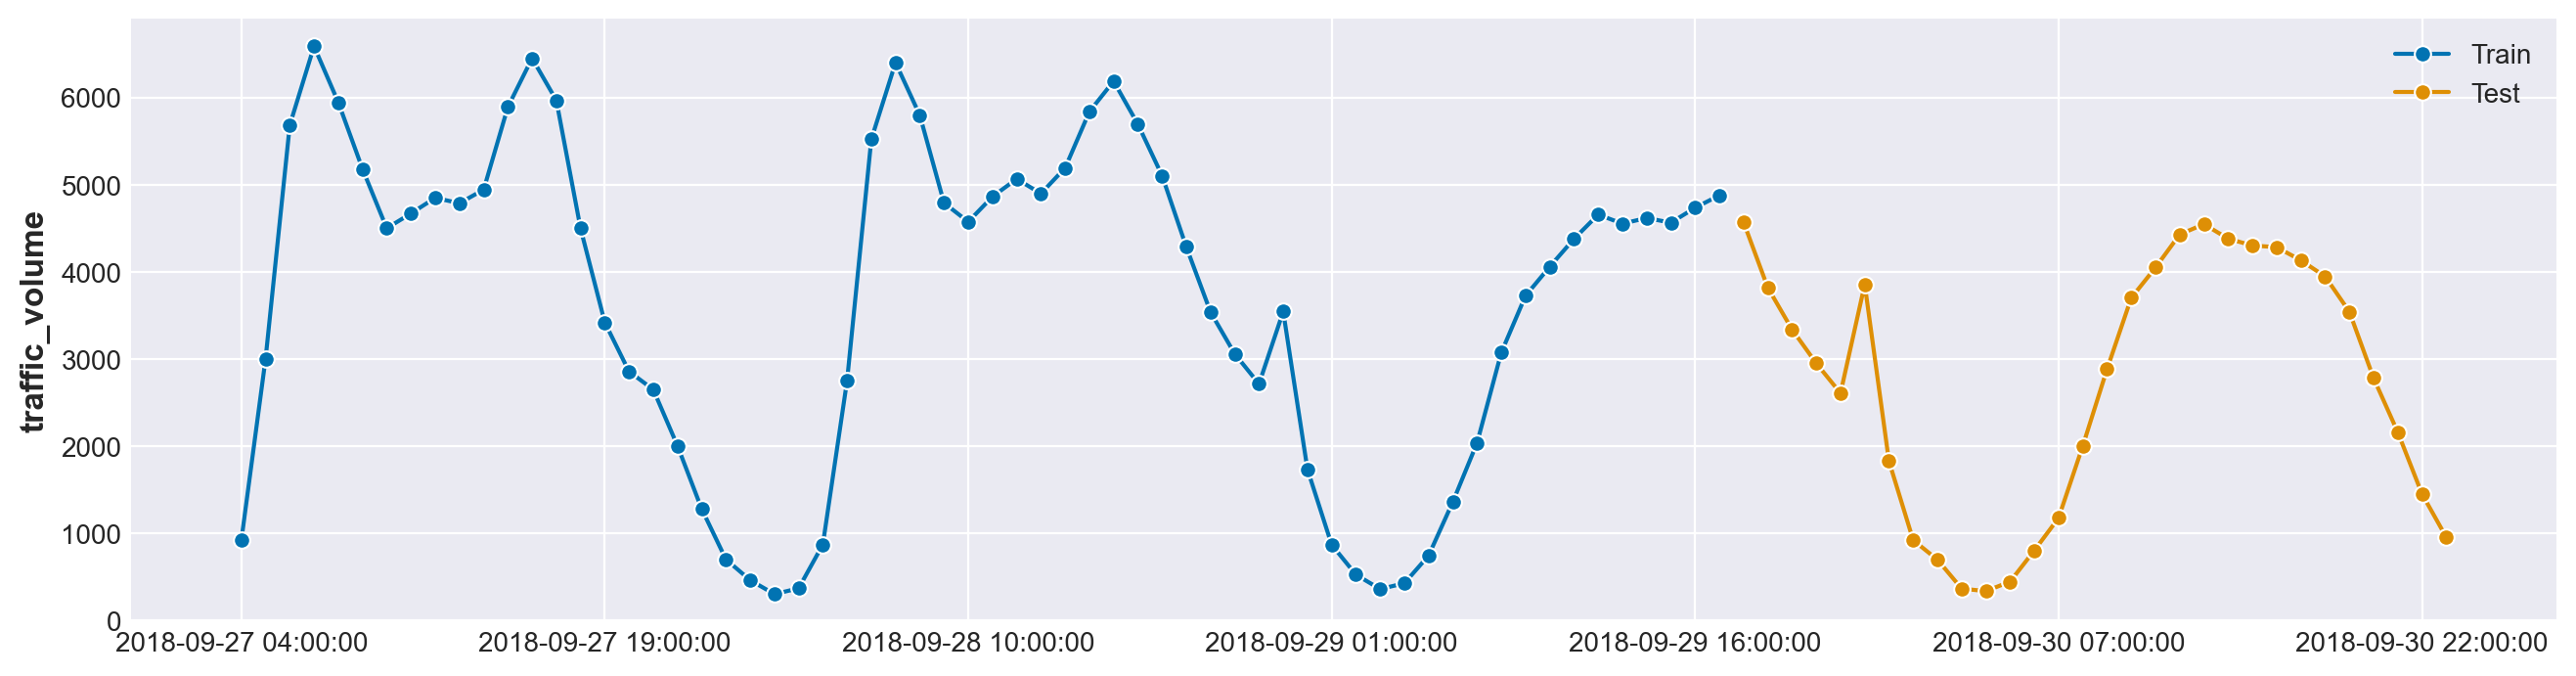

In [26]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "traffic_volume"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=2 * TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(62), y_test, labels=["Train", "Test"])

In [27]:
import warnings
from sktime.transformations.base import BaseTransformer


class ColumnsGuard(BaseTransformer):
    _tags = {
        "scitype:transform-input": "Series",
        # what is the scitype of X: Series, or Panel
        "scitype:transform-output": "Series",
        # what scitype is returned: Primitives, Series, Panel
        "scitype:transform-labels": "None",
        # what is the scitype of y: None (not needed), Primitives, Series, Panel
        "scitype:instancewise": True,  # is this an instance-wise transform?
        "capability:inverse_transform": True,  # can the transformer inverse transform?
        "univariate-only": False,  # can the transformer handle multivariate X?
        "X_inner_mtype": "pd.DataFrame",  # which mtypes do _fit/_predict support for X?
        # this can be a Panel mtype even if transform-input is Series, vectorized
        "y_inner_mtype": "None",  # which mtypes do _fit/_predict support for y?
        "requires_y": False,  # does y need to be passed in fit?
        "enforce_index_type": None,  # index type that needs to be enforced in X/y
        "fit_is_empty": False,  # is fit empty and can be skipped? Yes = True
        "X-y-must-have-same-index": True,  # can estimator handle different X/y index?
        "transform-returns-same-time-index": True,
        # does transform return have the same time index as input X
        "skip-inverse-transform": False,  # is inverse-transform skipped when called?
        "capability:unequal_length": True,
        # can the transformer handle unequal length time series (if passed Panel)?
        "capability:unequal_length:removes": True,
        # is transform result always guaranteed to be equal length (and series)?
        #   not relevant for transformers that return Primitives in transform-output
        "handles-missing-data": False,  # can estimator handle missing data?
        # todo: rename to capability:missing_values
        "capability:missing_values:removes": False,
        # is transform result always guaranteed to contain no missing values?
    }

    def __init__(self):
        super(ColumnsGuard, self).__init__()


    def _fit(self, X, y=None):
        self._columns_name = X.columns.tolist()
        return self

    # todo: implement this, mandatory
    def _transform(self, X, y=None):
        if self._columns_name == X.columns.tolist():
            X_transformed = X.copy(deep=True)
        else:
            missing_col = set(self._columns_name) - set(X.columns.tolist())
            extra_col = set(X.columns.tolist()) - set(self._columns_name)  
            if missing_col:
                raise ValueError('Missing columns: {missing_col}') 
            elif extra_col:
                warnings.warn('Got extra columns: {extra_col}, ignoring')
                X_transformed = X[self.self._columns_name].copy(deep=True)
        return X_transformed  

    def _inverse_transform(self, X, y=None):
        X_inv_transformed = X.copy(deep=True)
        return X_inv_transformed     

    @classmethod
    def get_test_params(cls, parameter_set="default"):
        params = {}
        return params

#### Huyper Parameter Selection 

intital_window_size 52446 , step_length 15 for fold 5


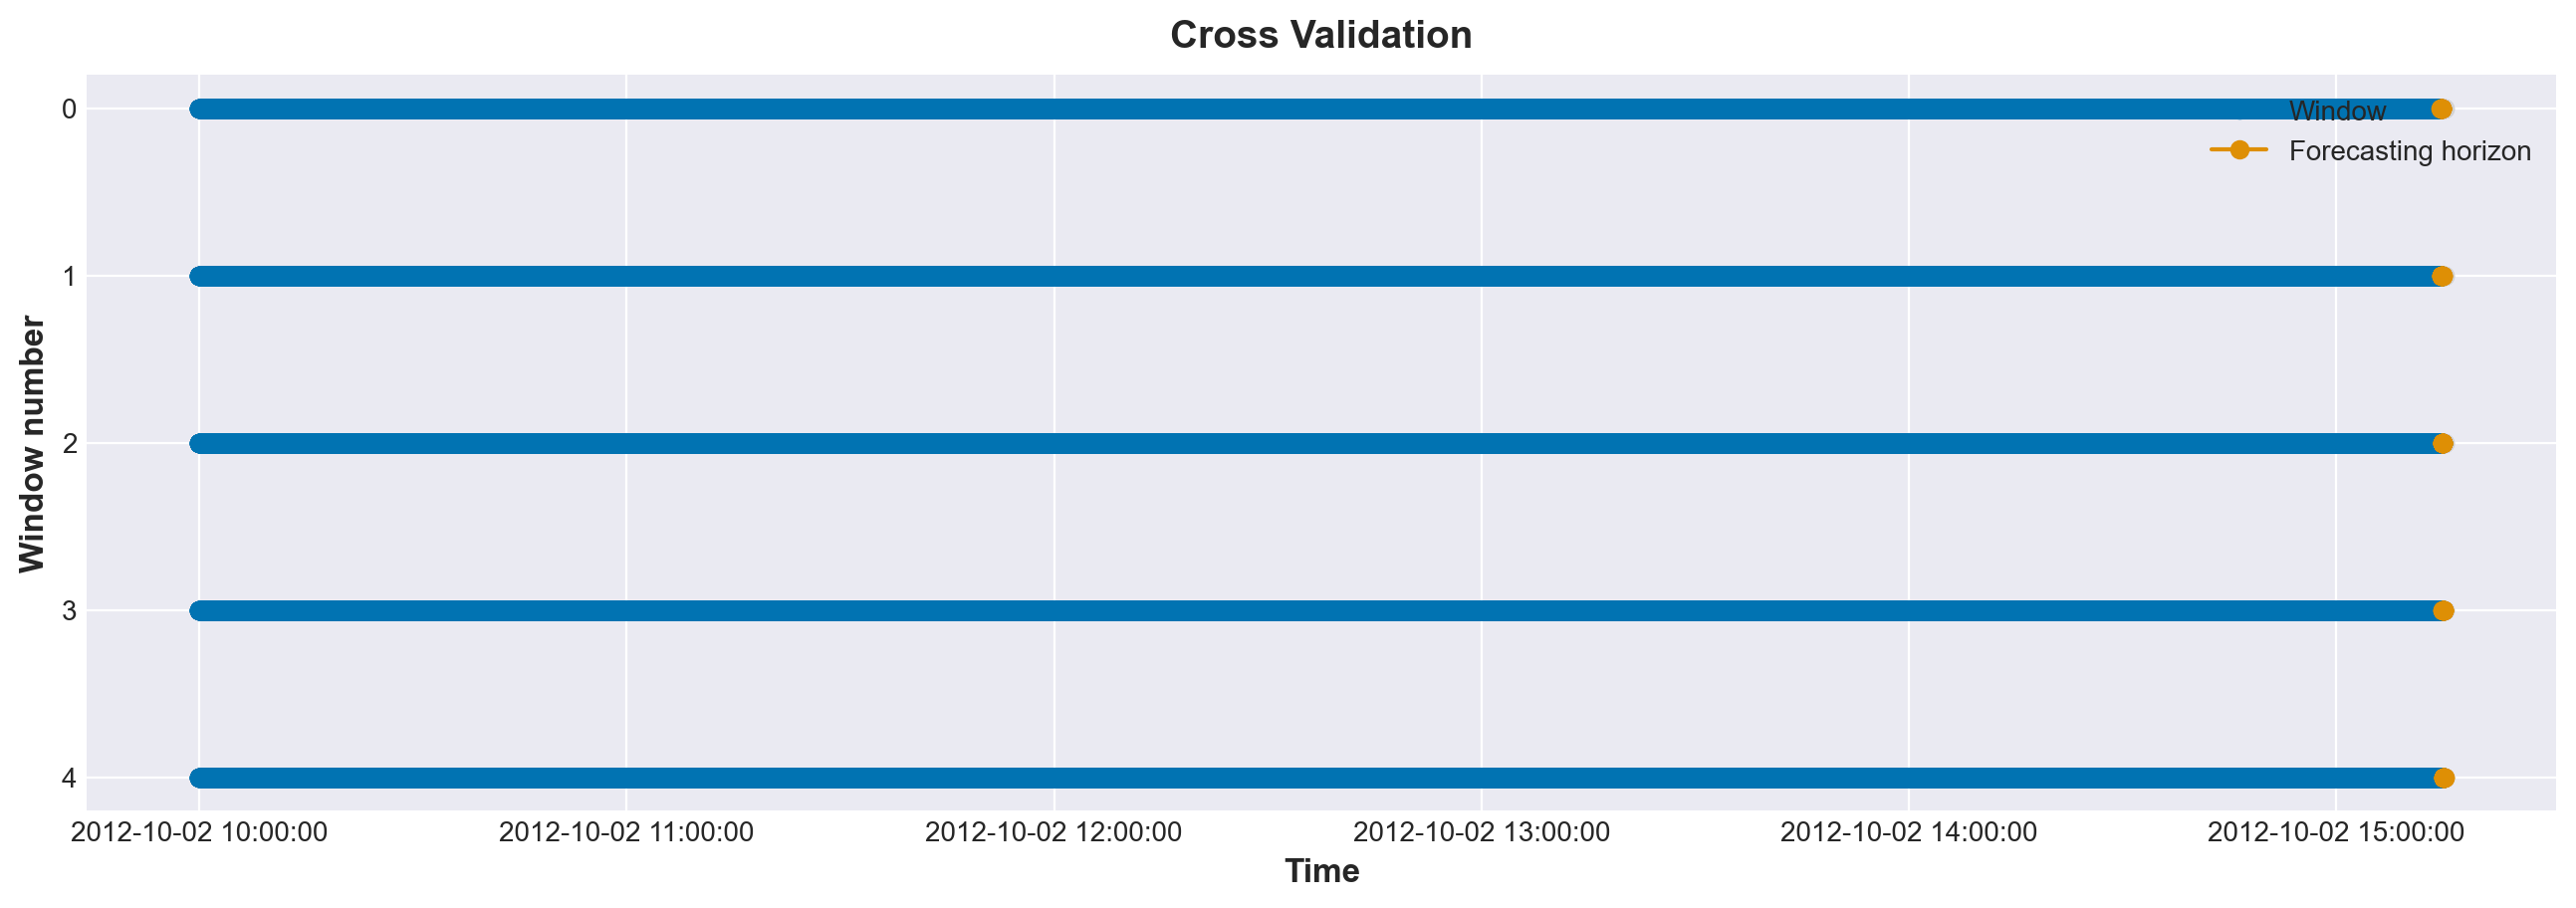

In [28]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [42]:
%%time

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import HuberRegressor

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsoluteError

param_grid = {
    # "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "scaler_x__passthrough": [True],
    "forecaster__deseasonalizer__model": ["additive"],
    "forecaster__deseasonalizer__sp": [24],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [24],
    "forecaster__reducer__estimator__epsilon": [1, 1.5, 1.9],
    "forecaster__reducer__estimator__alpha": [
        0.0000001,
        0.000001,
        0.00001,
        0.0001,
        0.001,
        0.01,
        0.1,
        0.9,
    ],
}

forecaster_pipe = ForecastingPipeline(
    steps=[
        ('column_Gaurd', ColumnsGuard()),
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        (
            "scaler_x",
            OptionalPassthrough(
                TabularToSeriesAdaptor(MinMaxScaler()), passthrough=False
            ),
        ),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=HuberRegressor(),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1

gscv = ForecastingGridSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsoluteError(),
    cv=cv,
    param_grid=param_grid,
    verbose=10,
    n_jobs=n_cpu,
    refit=True,
    error_score="raise",
)

gscv.fit(y_train, X=None, fh=fh)

print("Best Params", gscv.best_params_)
print("Best scores", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Number of CPU Count:   12
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params {'forecaster__deseasonalizer__model': 'additive', 'forecaster__deseasonalizer__sp': 24, 'forecaster__detrender__forecaster__degree': 1, 'forecaster__reducer__estimator__alpha': 1e-05, 'forecaster__reducer__estimator__epsilon': 1, 'forecaster__reducer__window_length': 24, 'scaler_x__passthrough': True}
Best scores 489.56465254891793
CPU times: total: 7.48 s
Wall time: 2min 38s


In [30]:
print(x_test.columns)

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all'], dtype='object')


2018-09-29 18:00:00    4633.922052
2018-09-29 19:00:00    4034.540601
2018-09-29 20:00:00    3527.017700
2018-09-29 21:00:00    3246.265821
2018-09-29 22:00:00    3107.827977
2018-09-29 23:00:00    2510.037065
2018-09-30 00:00:00    1768.376559
2018-09-30 01:00:00    1211.799069
2018-09-30 02:00:00     889.969774
2018-09-30 03:00:00     747.664220
2018-09-30 04:00:00     696.990094
2018-09-30 05:00:00    1266.957514
2018-09-30 06:00:00    2405.909877
2018-09-30 07:00:00    2915.439233
2018-09-30 08:00:00    3190.726790
Freq: H, Name: traffic_volume, dtype: float64

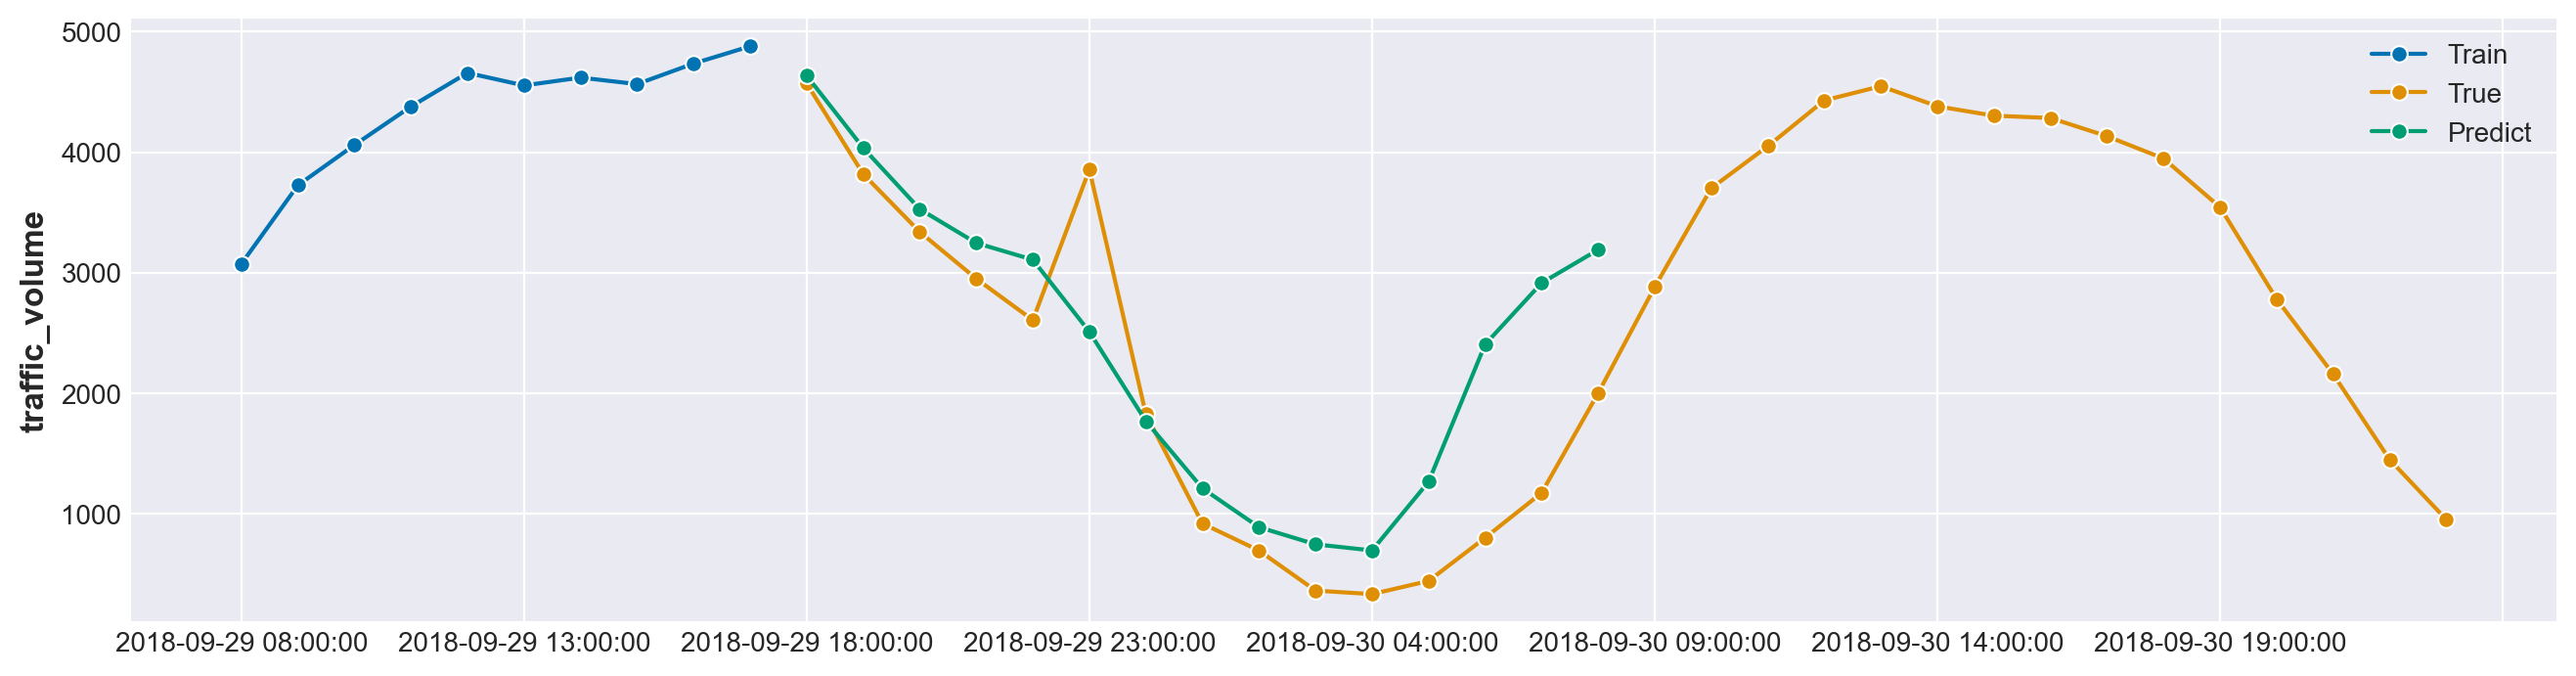

In [31]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [32]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

(48, 5)


,mean_test_MeanAbsoluteError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsoluteError
0,497.816022,4.700508,1.461525,{'forecaster__deseasonalizer__model': 'additiv...,8.0
1,498.139116,5.054433,1.283309,{'forecaster__deseasonalizer__model': 'additiv...,14.0
2,498.618424,4.925497,1.390367,{'forecaster__deseasonalizer__model': 'additiv...,21.0
3,498.040391,4.293604,1.757583,{'forecaster__deseasonalizer__model': 'additiv...,10.0
4,498.100151,4.715688,1.492468,{'forecaster__deseasonalizer__model': 'additiv...,12.0


### Backtesting Insample Prediction

In [33]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

losses = [
    MeanSquaredError(),
    MeanSquaredError(square_root=True),
    MeanAbsoluteError(),
    MeanAbsolutePercentageError(),
    MeanAbsolutePercentageError(symmetric=False),
    MeanAbsoluteScaledError(),
]

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=losses,
    return_data=True,
)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,test_MeanAbsoluteScaledError
0,385.463770,5.765283,0.532429,52446,2018-09-26 14:00:00,2012-10-02 09:00:00 5545.0 2012-10-02 10:00...,date_time 2018-09-26 15:00:00 5693.0 2018-0...,2018-09-26 15:00:00 5570.664124 2018-09-26 ...,264.914213,0.105232,0.548786
1,344.718400,5.926132,0.546671,52461,2018-09-27 05:00:00,2012-10-02 09:00:00 5545.0 2012-10-02 10:00...,date_time 2018-09-27 06:00:00 5685.0 2018-0...,2018-09-27 06:00:00 5137.767451 2018-09-27 ...,299.295481,0.062052,0.619925
2,283.722137,5.573335,0.493201,52476,2018-09-27 20:00:00,2012-10-02 09:00:00 5545.0 2012-10-02 10:00...,date_time 2018-09-27 21:00:00 2649.0 2018-0...,2018-09-27 21:00:00 2615.880487 2018-09-27 ...,205.416669,0.135288,0.425407
3,680.491402,5.339233,0.424828,52491,2018-09-28 11:00:00,2012-10-02 09:00:00 5545.0 2012-10-02 10:00...,date_time 2018-09-28 12:00:00 5066.0 2018-0...,2018-09-28 12:00:00 5026.135124 2018-09-28 ...,446.191943,0.158920,0.923911
4,1629.103381,6.348343,0.542772,52506,2018-09-29 02:00:00,2012-10-02 09:00:00 5545.0 2012-10-02 10:00...,date_time 2018-09-29 03:00:00 359.0 2018-0...,2018-09-29 03:00:00 443.919078 2018-09-29 ...,1270.588215,0.731464,2.630772


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='traffic_volume'>)

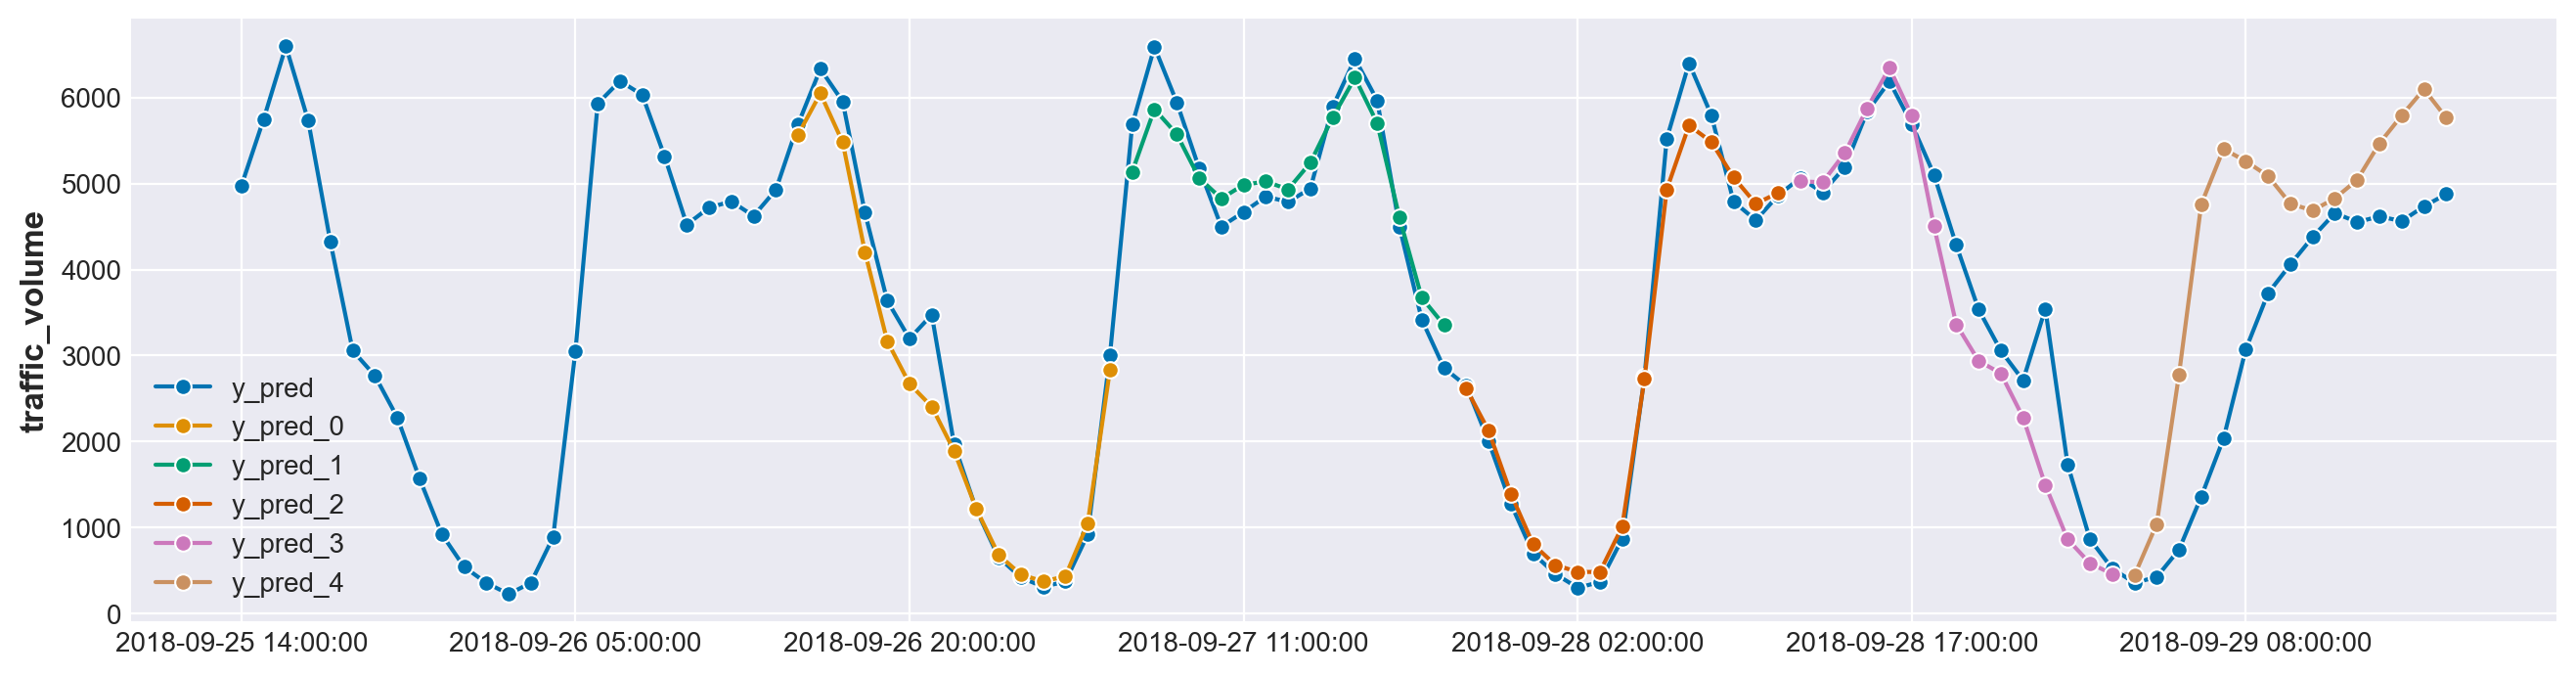

In [34]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [35]:
gscv.best_forecaster_.get_fitted_params()

{'forecaster': TransformedTargetForecaster(steps=[('imputer_y',
                                     Imputer(method='ffill', random_state=80)),
                                    ('deseasonalizer',
                                     ConditionalDeseasonalizer(sp=24)),
                                    ('detrender',
                                     Detrender(forecaster=PolynomialTrendForecaster())),
                                    ('reducer',
                                     RecursiveTabularRegressionForecaster(estimator=HuberRegressor(epsilon=1),
                                                                          pooling='global',
                                                                          window_length=24))]),
 'steps': [('column_Gaurd', ColumnsGuard()),
  ('x_transforner',
   TransformerPipeline(steps=[('imputer_x',
                               Imputer(method='ffill', random_state=80))])),
  ('scaler_x',
   OptionalPassthrough(passthrough=True,
 

### Train Model Parameter

In [36]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__coef"
]
model_intercept = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_coeff {model_coeff}", end="\n\n")
print(f"model_intercept {model_intercept}", end="\n\n")

model_n_features_in 28

model_fname_in ['traffic_volume_lag_1' 'traffic_volume_lag_2' 'traffic_volume_lag_3'
 'traffic_volume_lag_4' 'traffic_volume_lag_5' 'traffic_volume_lag_6'
 'traffic_volume_lag_7' 'traffic_volume_lag_8' 'traffic_volume_lag_9'
 'traffic_volume_lag_10' 'traffic_volume_lag_11' 'traffic_volume_lag_12'
 'traffic_volume_lag_13' 'traffic_volume_lag_14' 'traffic_volume_lag_15'
 'traffic_volume_lag_16' 'traffic_volume_lag_17' 'traffic_volume_lag_18'
 'traffic_volume_lag_19' 'traffic_volume_lag_20' 'traffic_volume_lag_21'
 'traffic_volume_lag_22' 'traffic_volume_lag_23' 'traffic_volume_lag_24'
 'temp' 'rain_1h' 'snow_1h' 'clouds_all']

model_coeff [ 1.03272341e+00 -2.37649602e-01 -4.39939628e-02 -1.56555648e-04
  3.24910840e-02 -3.05290633e-03 -3.26623058e-02  3.34602894e-02
  2.04904809e-02  3.16048953e-02 -6.32694669e-02 -9.97737641e-02
  6.26073555e-02  5.09123131e-02  1.30585238e-02 -6.11815214e-02
  3.55007429e-03  1.57114874e-02  1.38144420e-02 -3.31102376e-02
  8.84

In [37]:
x_train.tail()

,temp,rain_1h,snow_1h,clouds_all
date_time,,,,
2018-09-29 13:00:00,279.66,0.0,0.0,90.0
2018-09-29 14:00:00,280.31,0.0,0.0,90.0
2018-09-29 15:00:00,280.99,0.0,0.0,90.0
2018-09-29 16:00:00,281.41,0.0,0.0,90.0
2018-09-29 17:00:00,281.44,0.0,0.0,90.0


### model cutoff

In [38]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

DatetimeIndex(['2018-09-29 17:00:00'], dtype='datetime64[ns]', name='date_time', freq='H') 2018-09-29 17:00:00


### Model Cloning

In [39]:
from sklearn.base import clone

model = clone(gscv.best_forecaster_).set_params(**gscv.best_params_)

dir(model)

['_X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rpow__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_anytag_notnone_set',
 '_anytag_notnone_val',
 '_anytagis',
 '_anytagis_then_set',
 '_check_X',
 '_check_X_y',
 '_check_estimators',
 '_check_fh',
 '_check_names',
 '_check_steps',
 '_clone',
 '_clone_flags',
 '_coerce_estimator_tuple',
 '_components',
 '_config',
 '_config_dynamic',
 '_converter_store_y',
 '_cutoff',
 '_dunder_concat',
 '_fh',
 '_fit',
 '_get_class_flag',
 '_get_class_flags',
 '_get_estimator_list',
 '_get_estimator_names',
 '_get_estimator_tuples',
 '_get_fitted_params',
 '_get_fitted_params_default',


### Model saving 

In [40]:
# gscv.best_forecaster_.save("../results/elastic_net")

import joblib

joblib.dump(gscv.best_forecaster_, "../results/HuberRegressor.pkl")

['../results/HuberRegressor.pkl']

In [20]:
gscv.best_forecaster_.save("../results/HuberRegressor")

<zipfile.ZipFile filename='..\\results\\HuberRegressor.zip' mode='r'>

### Features importance

In [ ]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)

In [41]:
import joblib

trained_model = joblib.load("../results/HuberRegressor.pkl")